In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D,Dropout,Dense,BatchNormalization,MaxPooling2D,Flatten
from keras.models import Sequential
import seaborn as sns
import os


Using TensorFlow backend.


In [2]:
os.listdir('./cell_images')

['train', 'test']

In [3]:
MAIN_DIR = './cell_images/'
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
UNINFECTED = 'uninfected/'
INFECTED = 'parasitized/'
IMAGE_SIZE=(100,100)

dimn1=[]
dimn2=[]
Ufiles = os.listdir(MAIN_DIR+TRAIN_DIR+UNINFECTED)
for imgname in Ufiles:
    imgname = MAIN_DIR+TRAIN_DIR+UNINFECTED+imgname
    img = cv2.imread(imgname)
    if img is None:
        print(imgname)
        continue
    #print(img.shape)
    dim1,dim2,_  = img.shape
    dimn1.append(dim1)
    dimn2.append(dim2)

plt.figure(figsize=(12,12))
plt.scatter(x=dimn1,y=dimn2)

print(np.array(dimn1).mean())
print(np.array(dimn2).mean())

In [4]:

def create_data(Folder):
    data = []
    Ufiles = os.listdir(MAIN_DIR+Folder+UNINFECTED)
    print(MAIN_DIR+Folder+UNINFECTED)
    for imgname in Ufiles:
        imgname = MAIN_DIR+Folder+UNINFECTED+imgname
        img = cv2.imread(imgname)
        if img is None:
            print(imgname)
            continue
        #print(img.shape)
        img = cv2.resize(img,(130,130))
        data.append([img,'uninfected'])
        
    Ufiles = os.listdir(MAIN_DIR+Folder+INFECTED)
    for imgname in Ufiles:
        imgname = MAIN_DIR+Folder+INFECTED+imgname
        img = cv2.imread(imgname)
        if img is None:
            print(imgname)
            continue
        #print(img.shape)
        img = cv2.resize(img,(130,130))
        data.append([img,'infected'])
    return data

In [5]:
#train_data = create_data(TRAIN_DIR)
#data = []
#test_data = create_data(TEST_DIR)

In [6]:
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=20,width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,horizontal_flip=True,
                              fill_mode='nearest')

In [7]:
MAIN_DIR+TRAIN_DIR+INFECTED+os.listdir(MAIN_DIR+TRAIN_DIR+INFECTED)[10]

'./cell_images/train/parasitized/C99P60ThinF_IMG_20150918_140900_cell_104.png'

In [8]:
single_infected = cv2.imread(MAIN_DIR+TRAIN_DIR+INFECTED+os.listdir(MAIN_DIR+TRAIN_DIR+INFECTED)[10])
single_uninfected = cv2.imread(MAIN_DIR+TRAIN_DIR+UNINFECTED+os.listdir(MAIN_DIR+TRAIN_DIR+UNINFECTED)[10])

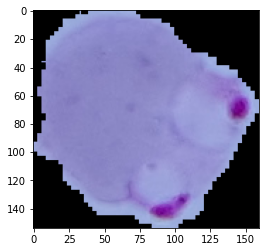

In [9]:
plt.imshow(single_infected)

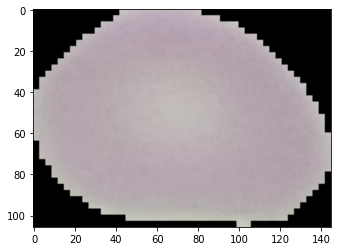

In [10]:
plt.imshow(single_uninfected)

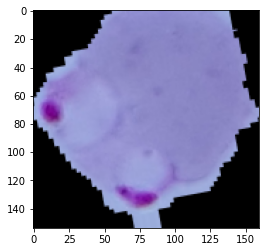

In [11]:
plt.imshow(image_gen.random_transform(single_infected))

In [12]:
#image_gen.flow_from_directory(MAIN_DIR+TRAIN_DIR)

In [13]:
model = Sequential()


model.add(Conv2D(16,kernel_size=(4,4),activation='relu',kernel_initializer='he_uniform',input_shape=(100,100,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,kernel_size=(4,4),activation='relu',kernel_initializer='he_uniform'))

model.add(Conv2D(64,kernel_size=(4,4),activation='relu',kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,kernel_initializer='he_uniform',kernel_size=(4,4)))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5)) 

model.add(Dense(1,activation='sigmoid'))

model.summary()
          



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 97, 97, 16)        784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       131200    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)        

In [14]:
from keras.callbacks import EarlyStopping

In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
train_image_gen = image_gen.flow_from_directory(MAIN_DIR+TRAIN_DIR
                                                ,target_size=IMAGE_SIZE,
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='binary'
                                               )
test_image_gen = image_gen.flow_from_directory(MAIN_DIR+TEST_DIR
                                              ,target_size=IMAGE_SIZE,
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='binary',
                                               shuffle=False
                                              )

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [18]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [19]:
results = model.fit_generator(train_image_gen,epochs=5,
                             validation_data=(test_image_gen),
                             callbacks=[early_stop])

Epoch 1/5
 503/1560 [========>.....................] - ETA: 4:01 - loss: 12.2326 - accuracy: 0.4981

KeyboardInterrupt: 

In [ ]:
model.save('./Models/malaria')
new_model = keras.models.load_model('./Models/malaria')